# Circuit Discovery Benchmarking Results

In [38]:
import re
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
import pandas as pd

In [4]:
sns.set_theme()
sns.set_style("whitegrid")
plt.style.use("alan.mplstyle")
ROOT = Path("../src/logic/data")

In [5]:
da = pickle.load(open(ROOT / "gemma-add-baseline-benchmark.pkl", "rb"))

## `Gemma-2-2b` Baseline Addition

In [223]:
def parse_ans(s):
    eqs = s.split("\n")
    target = eqs[3]
    ptrn = re.compile("(\d+)")
    result = target.split("=")
    question, ans = result[0], result[1]
    opr1, opr2 = question.split(" + ")
    if not (ans := re.search(ptrn, ans)):
        return False
    ans = ans.group(1)
    opr1, opr2 = int(opr1), int(opr2)
    return (opr1 + opr2) == int(ans)

def accuracy(v):
    return sum([parse_ans(qa) for qa in v]) / len(v)

probs_acc = {k : accuracy(v) for k, v in da.items()}

In [338]:
grid = np.zeros((8,8))

In [339]:
for k, v in probs_acc.items():
    grid[k[0]-1,k[1]-1] = v

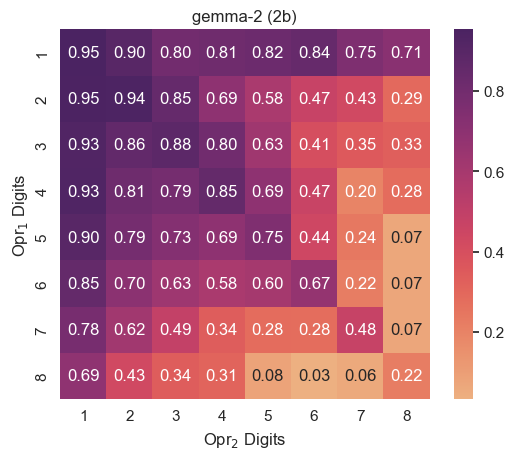

In [340]:
ax = sns.heatmap(grid, cmap="flare", annot=True, fmt=".2f", square=True, cbar=True)
ax.set_xticklabels(range(1,9))
ax.set_yticklabels(range(1,9))
ax.set_title("gemma-2 (2b)")
ax.set_ylabel("Opr$_1$ Digits")
ax.set_xlabel("Opr$_2$ Digits")
plt.savefig("gemma-2-add-benchmark.pdf")

Before: `number of layers * number of attention heads`

After: `total number of edges in computational graph`

## Circuit Equivalence

In [254]:
import json
import networkx as nx
from matplotlib.colors import ListedColormap

def rank_corr(df, method="spearman"):
    """Expects a dataframe with circuit indices as columns and
    the circuit components in the rows.
    """
    return df.corr(method=method)
    
def connected_comps(rc, thresh, index2label):
    """Expects a rank correlation matrix, a threshold to determine
    at what level are two circuits considered to be equal. Also takes
    in a dictionary that maps the labels of the columns into their actual
    labels.
    """
    adj = rc >= thresh
    G = nx.from_numpy_array(adj)
    components = list(nx.connected_components(G))
    components = [list(v) for v in components]
    return components, [[index2label[v] for v in comp] for comp in components]

def process_graph_file(fname):
    f = json.load(open(fname, "r"))
    return {k: v["score"] for k,v in f["edges"].items()}

def cc_graph(ccs):
    """Visualizes the connected components as a graph.
    """
    G = nx.Graph()
    shape_l = 'os^v<>*pHD'
    for comp_id, component in enumerate(ccs):
        for node in component:
            G.add_node(tuple(node), color=comp_id, node_shape=shape_l[comp_id % len(shape_l)])
    for component in ccs:
        for r, c in component:
            neighbors = [(r+1, c), (r-1, c), (r, c+1), (r, c-1),(r-1,c+1), (r-1,c-1), (r+1,c-1), (r+1,c+1)]  # 4-neighbor adjacency
            for neighbor in neighbors:
                if neighbor in component:
                    G.add_edge((r, c), neighbor)
    spanning_trees = []
    
    for component in ccs:
        # Create a subgraph for the component
        subgraph = G.subgraph(component)
        # Compute the minimum spanning tree (MST) for this subgraph
        mst = nx.minimum_spanning_tree(subgraph)
        spanning_trees.append(mst)
    # Combine the spanning trees into a new graph
    G_mst = nx.Graph()
    for mst in spanning_trees:
        G_mst.add_nodes_from(mst.nodes())
        G_mst.add_edges_from(mst.edges())
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    nshapes = {k: shape_l[G.nodes[k]["color"] % len(shape_l)] for k in G.nodes}
    pos = {node: (node[1], -node[0]) for node in G_mst.nodes}
    colors = {n: G.nodes[n]["color"] for n in G_mst.nodes}
    nlabels = {k: f"{k[0]},{k[1]}" for k in G.nodes}
    cmap = ListedColormap(sns.color_palette("hls", len(ccs)))
    for node, shape in nshapes.items():
        nx.draw_networkx_nodes(G_mst, pos, nodelist=[node], node_size=600, node_shape=shape, node_color=cmap(colors[node]))
    
    # Draw the edges
    nx.draw_networkx_edges(G_mst, pos, width=5)
    nx.draw_networkx_labels(G_mst, pos, labels=nlabels, font_size=7, font_weight="bold")

## Circuit Grouping (`Gemma-2-2b` Addition)

In [282]:
index2label = {}
cols = []
for opr1 in range(1, 9):
    for opr2 in range(1, 9):
        col = process_graph_file(ROOT / f"gemma-add-{opr1}{opr2}.json")
        cols.append(col)
        index2label[len(cols) - 1] = (opr1, opr2)

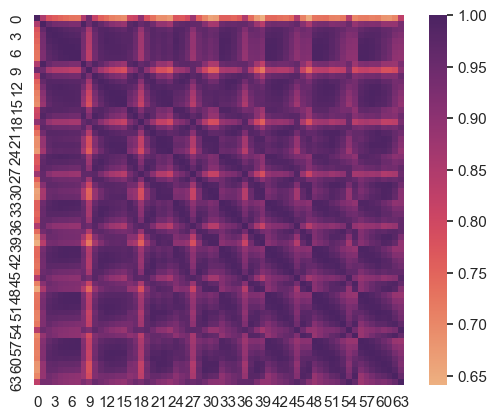

In [390]:
sns.heatmap(df.corr(), cmap="flare", square=True, cbar=True)
plt.show()

In [283]:
df = pd.DataFrame(cols).T
rank_corr_spear = rank_corr(df).values

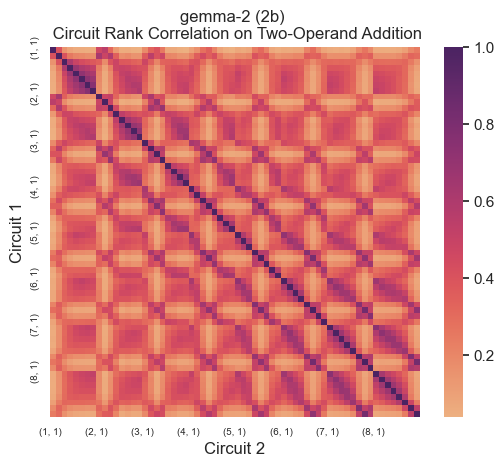

In [284]:
ax = sns.heatmap(rank_corr_spear, cmap="flare", square=True, cbar=True)
ax.set_xticks(range(0,rank_corr_spear.shape[1], 8))
ax.set_yticks(range(0,rank_corr_spear.shape[0], 8))
ax.set_xticklabels([index2label[i] for i in range(0,rank_corr_spear.shape[1], 8)], fontsize=7)
ax.set_yticklabels([index2label[i] for i in range(0,rank_corr_spear.shape[0], 8)], fontsize=7)
ax.set_title("gemma-2 (2b) \n Circuit Rank Correlation on Two-Operand Addition")
ax.set_ylabel("Circuit 1")
ax.set_xlabel("Circuit 2")
plt.show()

**Reflexivity:** Say define $A \simeq B$ as $A$ is 60% correlated with $B$. Then, $A \simeq B$ and $B \simeq C$ doesn't imply $A \simeq C$. 

In [498]:
_, weak_ccs = connected_comps(rank_corr_spear, 0.6, index2label)

/Users/alansun/miniconda3/envs/ml/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


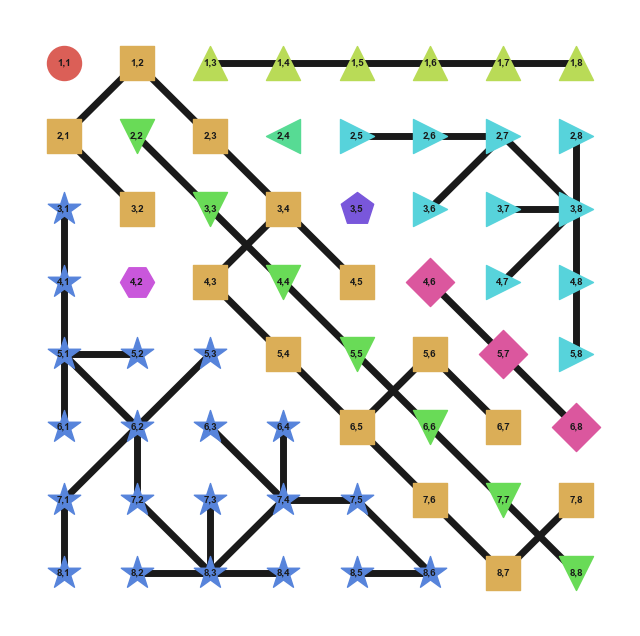

In [530]:
cc_graph(weak_ccs)
plt.savefig("gemma-2-2b-connected.pdf")
plt.show()

In [479]:
_, prime_ccs = connected_comps(rank_corr_spear, 0.63, index2label)

/Users/alansun/miniconda3/envs/ml/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


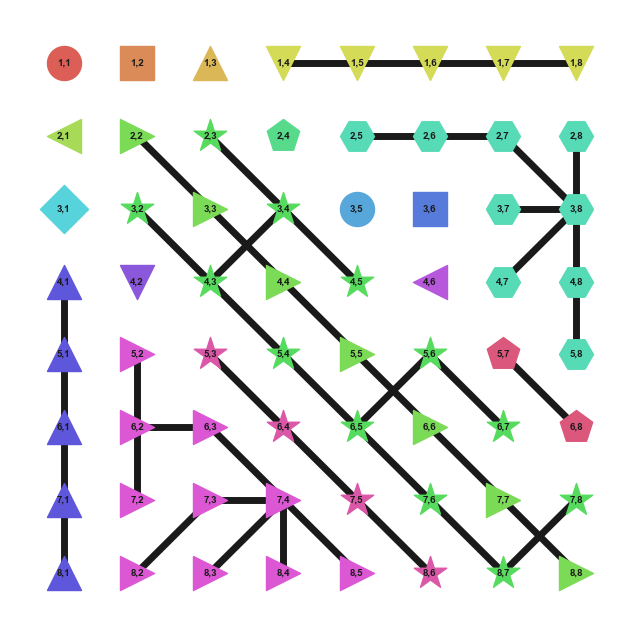

In [480]:
cc_graph(prime_ccs)

In [442]:
_, ccs = connected_comps(rank_corr_spear, 0.65, index2label)

/Users/alansun/miniconda3/envs/ml/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


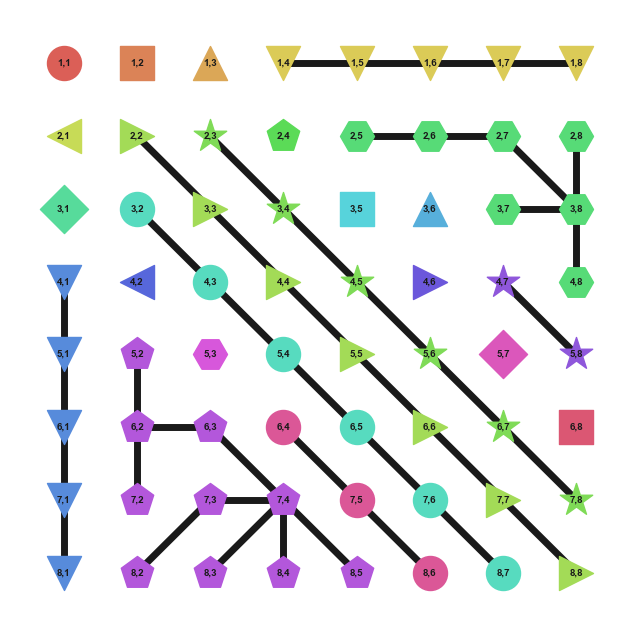

In [443]:
cc_graph(ccs)

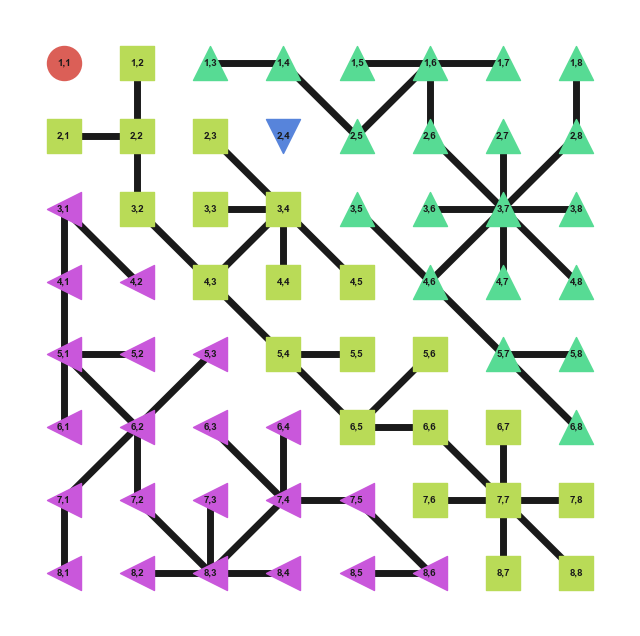

In [540]:
_, ccs = connected_comps(rank_corr_spear, 0.55, index2label)
cc_graph(ccs)

In [412]:
ranks = df.rank()
ranks.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
input->a0.h0<q>,74050.0,118.0,72106.0,72790.0,69734.0,69171.0,10918.0,4366.0,72385.0,46.0,...,330.0,73544.0,70911.0,69581.0,71779.0,2900.0,72711.0,71060.0,73574.0,253.0
input->a0.h0<k>,74109.5,73.5,1127.5,72486.5,3038.5,1192.5,72224.5,73249.5,139.5,74029.5,...,74114.5,73995.5,73065.5,73668.5,73544.5,73404.5,73669.5,73681.5,73832.5,74130.5
input->a0.h0<v>,74053.5,42.5,74107.5,74077.5,74076.5,74057.5,74068.5,74076.5,73849.5,14.5,...,74183.5,74139.5,74071.5,74076.5,74092.5,74079.5,74109.5,74119.5,74135.5,74181.5
input->a0.h1<q>,24.0,169.0,78.0,48.0,44.0,42.0,39.0,39.0,241.0,73878.0,...,63.0,132.0,43.0,45.0,45.0,56.0,54.0,61.0,113.0,81.0
input->a0.h1<k>,74109.5,73.5,1127.5,72486.5,3038.5,1192.5,72224.5,73249.5,139.5,74029.5,...,74114.5,73995.5,73065.5,73668.5,73544.5,73404.5,73669.5,73681.5,73832.5,74130.5


In [449]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=3)
d2 = tsne.fit_transform(ranks.T)

In [513]:
ccs = weak_ccs

label2index = {v : k for k,v in index2label.items()}
groupids2index = {i: [label2index[v] for v in ccs[i]] for i in range(len(ccs))}
index2groupid = dict()
for k, v in groupids2index.items():
    for index in v:
        index2groupid[index] = k

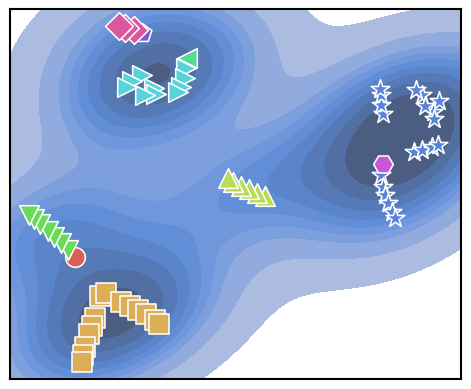

In [533]:
ax = sns.kdeplot(x=d2[:,0], y=d2[:,1], fill=True)

mlabels = "os^v<>*pHD"
cmap = ListedColormap(sns.color_palette("hls", len(groupids2index)))

for i, row in enumerate(d2):
    ax = sns.scatterplot(x=[d2[i,0]], y=[d2[i,1]], marker=mlabels[index2groupid[i] % len(mlabels)],color=cmap(index2groupid[i]), s=200)

# for i, row in enumerate(d2):
#     ax.annotate(index2label[i], (row[0], row[1]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=7)

y_min, y_max = min(d2[:,1]), max(d2[:,1])
x_min, x_max = min(d2[:,0]), max(d2[:,0])

ax.set_ylim(y_min * 1.1, y_max * 1.1)
ax.set_xlim(x_min * 1.1, x_max * 1.1)

ax.set_aspect("equal", adjustable="box")
plt.xticks([])
plt.yticks([])
plt.savefig("gemma-2b-tsne.pdf")
plt.show()

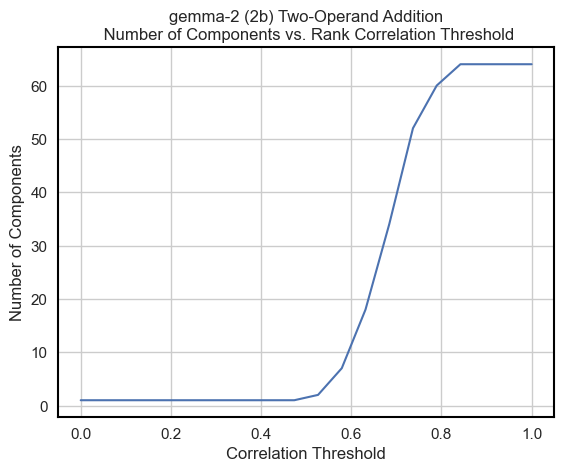

In [541]:
prcts = np.linspace(0, 1, 20)
comps = []
for prct in prcts:
    _, ccs = connected_comps(rank_corr_spear, prct, index2label)
    comps.append(len(ccs))
sns.lineplot(x=prcts, y=comps)
plt.title("gemma-2 (2b) Two-Operand Addition\n Number of Components vs. Rank Correlation Threshold")
plt.ylabel("Number of Components")
plt.xlabel("Correlation Threshold")
plt.savefig("gemma-components-vs-rank-correlation.pdf")

## `Phi-1.5` Baseline Boolean

**Expression Length:** `True and not False = 4`

**Parenthetical Depth:** `((True) and not False) = 2`

In [341]:
da = pickle.load(open(ROOT / "phi-1_5-benchmark-bool.pkl", "rb"))

In [343]:
grid = np.zeros((7,6))
for k,v in da.items():
    grid[k[0] - 3][k[1] - 1] = v[0]

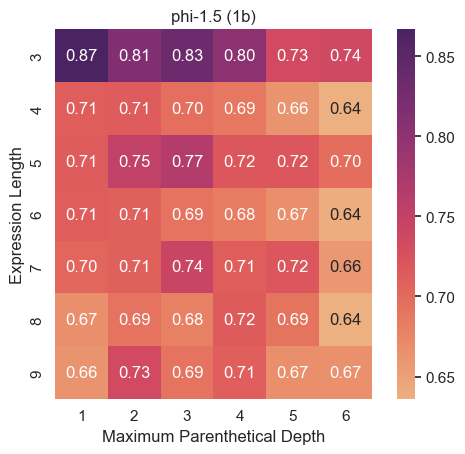

In [344]:
ax = sns.heatmap(grid, cmap="flare", annot=True, fmt=".2f", square=True, cbar=True)
ax.set_xticklabels(range(1,7))
ax.set_yticklabels(range(3,10))
ax.set_title("phi-1.5 (1b)")
ax.set_ylabel("Expression Length")
ax.set_xlabel("Maximum Parenthetical Depth")
plt.savefig("phi-1.5-bool-benchmark.pdf")

## Circuit Grouping (`Phi-1.5` Boolean) 

In [345]:
index2label_bool = {}
cols_bool = []
for exp_l in range(3, 10):
    for depth in range(1, 7):
        col = process_graph_file(ROOT / f"phi-1_5-bool-{exp_l}{depth}.json")
        cols_bool.append(col)
        index2label_bool[len(cols_bool) - 1] = (exp_l, depth)

In [346]:
df_bool = pd.DataFrame(cols_bool).T

In [362]:
rank_corr_spear_bool = rank_corr(df_bool)

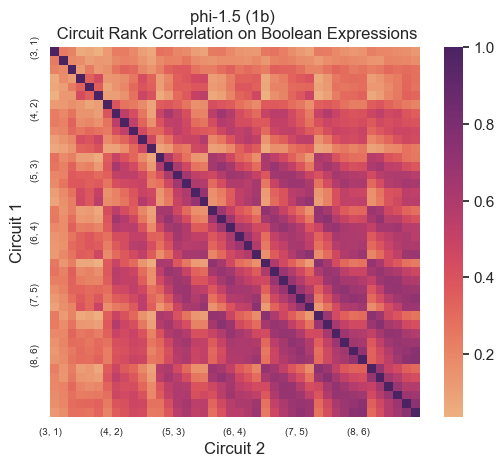

In [405]:
ax = sns.heatmap(rank_corr_spear_bool, cmap="flare", square=True, cbar=True)
ax.set_xticks(range(0,rank_corr_spear_bool.shape[1], 7))
ax.set_yticks(range(0,rank_corr_spear_bool.shape[0], 7))
ax.set_xticklabels([index2label_bool[i] for i in range(0,rank_corr_spear_bool.shape[1], 7)], fontsize=7)
ax.set_yticklabels([index2label_bool[i] for i in range(0,rank_corr_spear_bool.shape[0], 7)], fontsize=7)
ax.set_title("phi-1.5 (1b) \n Circuit Rank Correlation on Boolean Expressions")
ax.set_ylabel("Circuit 1")
ax.set_xlabel("Circuit 2")
plt.savefig("circuit-rank-corr-bool.pdf")

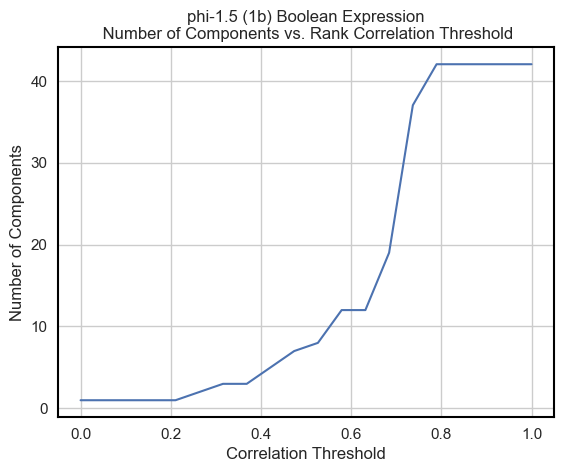

In [406]:
prcts = np.linspace(0, 1, 20)
comps = []
for prct in prcts:
    _, ccs = connected_comps(rank_bool_corr.values, prct, index2label_bool)
    comps.append(len(ccs))
sns.lineplot(x=prcts, y=comps)
plt.title("phi-1.5 (1b) Boolean Expression\n Number of Components vs. Rank Correlation Threshold")
plt.ylabel("Number of Components")
plt.xlabel("Correlation Threshold")
plt.savefig("phi-1.5-bool-thresh.pdf")

Text(0.5, 0, 'Correlation Threshold')

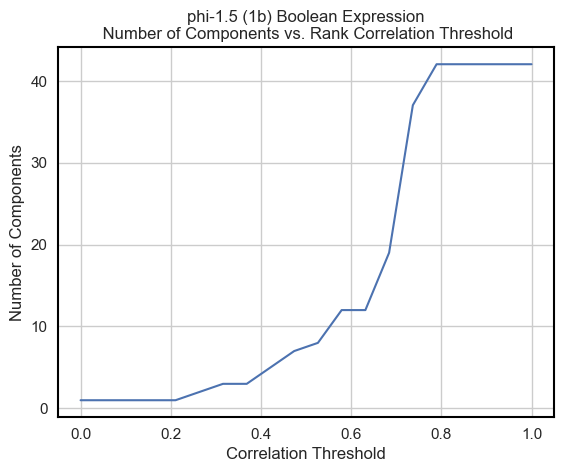

In [308]:
prcts = np.linspace(0, 1, 20)
comps = []
for prct in prcts:
    _, ccs = connected_comps(rank_corr_spear_bool, prct, index2label_bool)
    comps.append(len(ccs))
sns.lineplot(x=prcts, y=comps)
plt.title("phi-1.5 (1b) Boolean Expression\n Number of Components vs. Rank Correlation Threshold")
plt.ylabel("Number of Components")
plt.xlabel("Correlation Threshold")

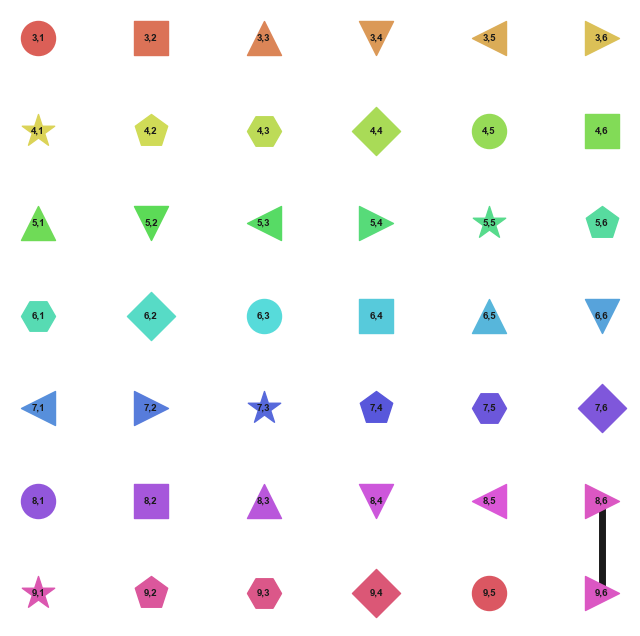

In [555]:
_, ccs = connected_comps(rank_corr_spear_bool.values, 0.751, index2label_bool)
cc_graph(ccs)

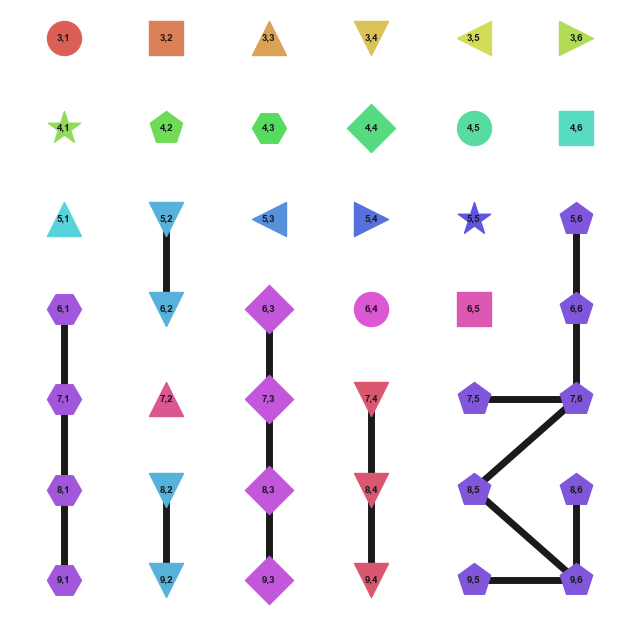

In [361]:
_, ccs = connected_comps(rank_corr_spear_bool, 0.7, index2label_bool)
cc_graph(ccs)

### `Phi-1.5` Boolean Expression Evaluation Precedence

In [368]:
only_not, only_or, only_and = (
    pickle.load(open(ROOT / "phi-1_5-only-not-benchmark.pkl", "rb")),
    pickle.load(open(ROOT / "phi-1_5-only-or-benchmark.pkl", "rb")),
    pickle.load(open(ROOT / "phi-1_5-only-and-benchmark.pkl", "rb")),
)

In [369]:
no_paran_only_not, no_paran_only_or, no_paran_only_and = (
    pickle.load(open(ROOT / "no-paran-phi-1_5-only-not-benchmark.pkl", "rb")),
    pickle.load(open(ROOT / "no-paran-phi-1_5-only-or-benchmark.pkl", "rb")),
    pickle.load(open(ROOT / "no-paran-phi-1_5-only-and-benchmark.pkl", "rb")),
)

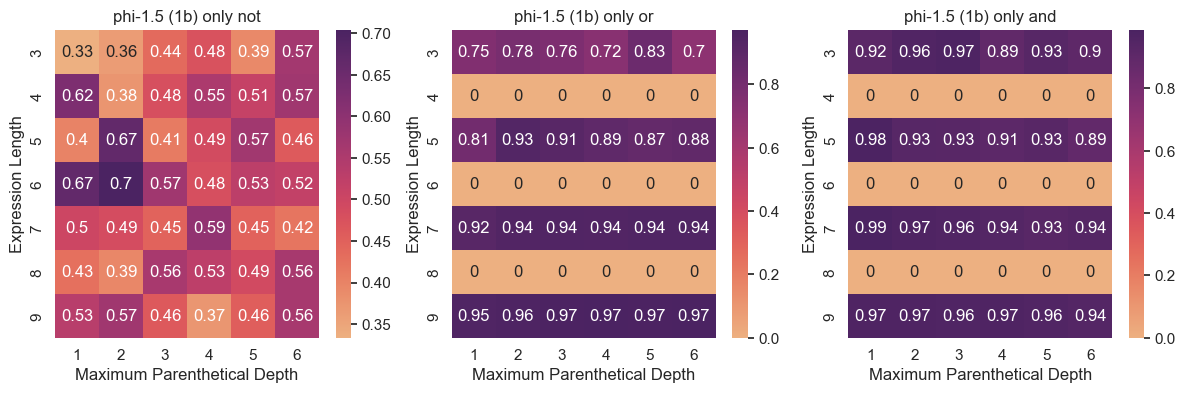

In [386]:
fig, axs = plt.subplots(1,3, figsize=(14.5,4))
titles = ["only not", "only or", "only and"]
for i, mat in enumerate([only_not, only_or, only_and]):
    grid = np.zeros((7,6))
    for k, v in mat.items():
        grid[k[0] - 3][k[1] - 1] = v[0]
    ax = sns.heatmap(grid, cmap="flare", annot=True, square=True, ax=axs[i], cbar=True)
    ax.set_xticklabels(range(1,7))
    ax.set_yticklabels(range(3,10))
    ax.set_title("phi-1.5 (1b) " + titles[i])
    ax.set_ylabel("Expression Length")
    ax.set_xlabel("Maximum Parenthetical Depth")

In [395]:
pareto = json.load(open(ROOT / "phi-1_5-bool-31-pareto.json"))

In [396]:
pareto.keys()

dict_keys(['perf', 'components'])

In [397]:
x = pareto["components"]
y = pareto["perf"]

In [401]:
y

[0.13333334028720856,
 0.13333334028720856,
 0.13333334028720856,
 0.10000000894069672,
 0.13333334028720856,
 0.13333334028720856,
 0.13333334028720856,
 0.2666666805744171,
 0.30000001192092896,
 0.6333333849906921,
 0.7333333492279053,
 0.7666667103767395,
 0.8333333730697632,
 0.8000000715255737]

[]

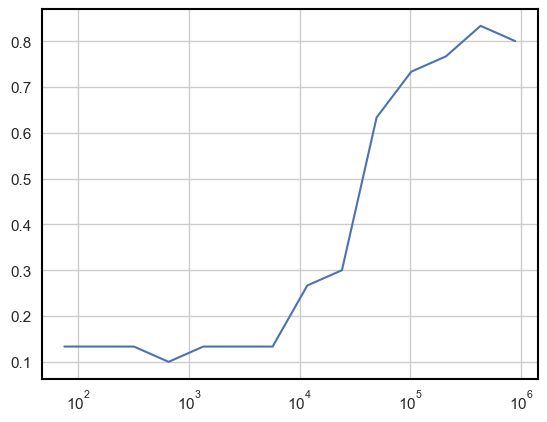

In [404]:
ax = sns.lineplot(x=x[len(x) - len(y):],y=y)
ax.set(xscale='log')
plt.plot()